In [557]:
import torch
import math
import numpy as np
from torch import nn
import random
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import chart_studio.tools as tls
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pandas as pd
import copy 
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from celluloid import Camera
import time

# Showing how a Linear NN works on various datasets 

## First generate some data

In [751]:
#Check if point is in the circle or not
def in_circle(center, radius, point):
    x = abs(center[0] - point[0])
    y = abs(center[1] - point[1])
    distance = math.sqrt(x**2+y**2)
    if distance < radius:
        return 1
    else: 
        return 0

def in_square(center, width, height, point):
    xmin = center[0] - width
    xman = center[0] + width
    ymin = center[1] - height
    ymax = center[1] + height
    if xmin < point[0] < xman and ymin < point[1] < ymax:
        return 1
    else: 
        return 0
    
def in_rotated_sin(point):
    # y=sin(x) + x
    y = math.sin(point[0]) + point[0]
    if point[1]>y:
        return 1
    else: 
        return 0
def in_sin(point):
    # y=sin(x)*4
    y = math.sin(point[0])*4
    if point[1]>y:
        return 1
    else: 
        return 0

def generateCircle(n_points, center, radius):
    data = []
    columns = ['x', 'y', 'out']
    df = pd.DataFrame(columns = columns)
    for n in range(n_points): 
        x = random.uniform(0, 10)
        y = random.uniform(0, 10)
        output = in_circle(center, radius, [x,y])
        df = df.append({'x':x, 'y': y, 'out': output}, ignore_index = True)
    return df

def generateSquare(n_points, center, width, height):
    data = []
    columns = ['x', 'y', 'out']
    df = pd.DataFrame(columns = columns)
    for n in range(n_points): 
        x = random.uniform(0, 10)
        y = random.uniform(0, 10)
        output = in_square(center, width, height, [x,y])
        df = df.append({'x':x, 'y': y, 'out': output}, ignore_index = True)
    return df

def generateSin(n_points):
    data = []
    columns = ['x', 'y', 'out']
    df = pd.DataFrame(columns = columns)
    for n in range(n_points): 
        x = random.uniform(0, 10)
        y = random.uniform(0, 10)
        output = in_sin([x,y])
        df = df.append({'x':x, 'y': y, 'out': output}, ignore_index = True)
    return df

def generateRotatedSin(n_points):
    data = []
    columns = ['x', 'y', 'out']
    df = pd.DataFrame(columns = columns)
    for n in range(n_points): 
        x = random.uniform(0, 10)
        y = random.uniform(0, 10)
        output = in_rotated_sin([x,y])
        df = df.append({'x':x, 'y': y, 'out': output}, ignore_index = True)
    return df
        


In [752]:
cirlce = generateCircle(2000, [5,5], 2)
square = generateSquare(2000, [5,5], 2, 2)
sin = generateSin(2000)
rotated_sin = generateRotatedSin(2000)

### Visualise the data we are trying to fit

In [1]:
fig = make_subplots(rows=2, cols=2)
fig.add_trace(
    go.Scatter(x=cirlce['x'], y = cirlce['y'], 
               marker = dict(color=cirlce['out']), mode = 'markers'),
    row=1, col=1
)
#fig.add_trace(go.scatter(x=cirlce['x'], y = cirlce['y'], color = cirlce['out']), row=1, col=1)
fig.add_shape(type="circle",
    xref="x", yref="y",
    fillcolor="orange",
    opacity=0.2,
    x0=3, y0=3, x1=7, y1=7,      
    line_color="red",
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=square['x'], y = square['y'], 
               marker = dict(color=square['out']), mode = 'markers'),
    row=1, col=2
)
#fig.add_trace(go.scatter(x=cirlce['x'], y = cirlce['y'], color = cirlce['out']), row=1, col=1)
fig.add_shape(type="rect",
    xref="x", yref="y",
    fillcolor="orange",
    opacity=0.2,
    x0=3, y0=3, x1=7, y1=7,      
    line_color="red",
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=sin['x'], y = sin['y'], 
               marker = dict(color=sin['out']), mode = 'markers'),
    row=2, col=1
)
t = np.linspace(0, 10, 100)


fig.add_trace(
    go.Scatter(x=t, y = np.sin(t)*4,  mode = 'lines'),
    row=2, col=1
)


fig.add_trace(
    go.Scatter(x=rotated_sin['x'], y = rotated_sin['y'], 
               marker = dict(color=rotated_sin['out']), mode = 'markers'),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(x=t, y = np.sin(t)+t,  mode = 'lines'),
    row=2, col=2
)

fig.update_yaxes(range=[0, 10], row=1, col=1)
fig.update_yaxes(range=[0, 10], row=1, col=2)
fig.update_yaxes(range=[0, 10], row=2, col=1)
fig.update_yaxes(range=[0, 10], row=2, col=2)
fig.update_xaxes(range=[0, 10], row=1, col=1)
fig.update_xaxes(range=[0, 10], row=1, col=2)
fig.update_xaxes(range=[0, 10], row=2, col=1)
fig.update_xaxes(range=[0, 10], row=2, col=2)
fig.update_layout(width=1600, height=1600)
#fig.show()

NameError: name 'make_subplots' is not defined

## Create the model

In [755]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.MLP = nn.Sequential(
            self.get_linear_block(2,8),
            self.get_linear_block(8,8),
            self.get_linear_block(8,8),
            self.get_linear_block(8,8),
            nn.Linear(8,1),

            #self.get_linear_block(8,1),
            nn.Sigmoid(),
        )
    
    def get_linear_block(self, input_dim,output_dim):
        return nn.Sequential(
            nn.Linear(input_dim,output_dim),
            #nn.Sigmoid(),
            nn.LeakyReLU(0.1),
         )

    
    def forward(self, x):
        return self.MLP(x)
        
    

In [937]:
a = MLP()
a

MLP(
  (MLP): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [756]:
torch.cuda.device_count()

1

In [757]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

# Create lists to hold histories of each model

In [866]:
circle_loss_history = []
circle_model_history = []

square_loss_history = []
square_model_history = []

sin_loss_history = []
sin_model_history = []

rotated_sin_loss_history = []
rotated_sin_model_history = []

## Convert data to tensors

In [919]:
def select_data(data):
    x_train_tensor = torch.tensor([data['x'],data['y']], requires_grad=True, device = device)
    x_train_tensor = torch.transpose(x_train_tensor, 0, 1)
    out_train_tensor = torch.tensor(data['out'], device = device)
    return x_train_tensor, out_train_tensor
#cirlce, square, sin, rotated_sin
x_train_tensor, out_train_tensor = select_data(rotated_sin)

## Train the Data

In [920]:
device = torch.device("cuda")
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = torch.nn.BCELoss()
model = model.double()
model.train()
model.cuda()
epochs = 30001
start = time.time()
loss_history = []
model_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    #Forward Pass
    y_pred = model(x_train_tensor)
    
    #Calculate Loss
    loss = criterion(y_pred.squeeze(), out_train_tensor)
    #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        #print("copying model at: " + str(epoch) + " Time Elapsed: " + str(time.time()-start))
        rotated_sin_model_history.append(copy.deepcopy(model))
    
    #Back Prop
    loss.backward()
    optimizer.step()
end = time.time()
total = end-start
print("Model took: " +str(total))

rotated_sin_loss_history = loss_history

Model took: 120.33071374893188


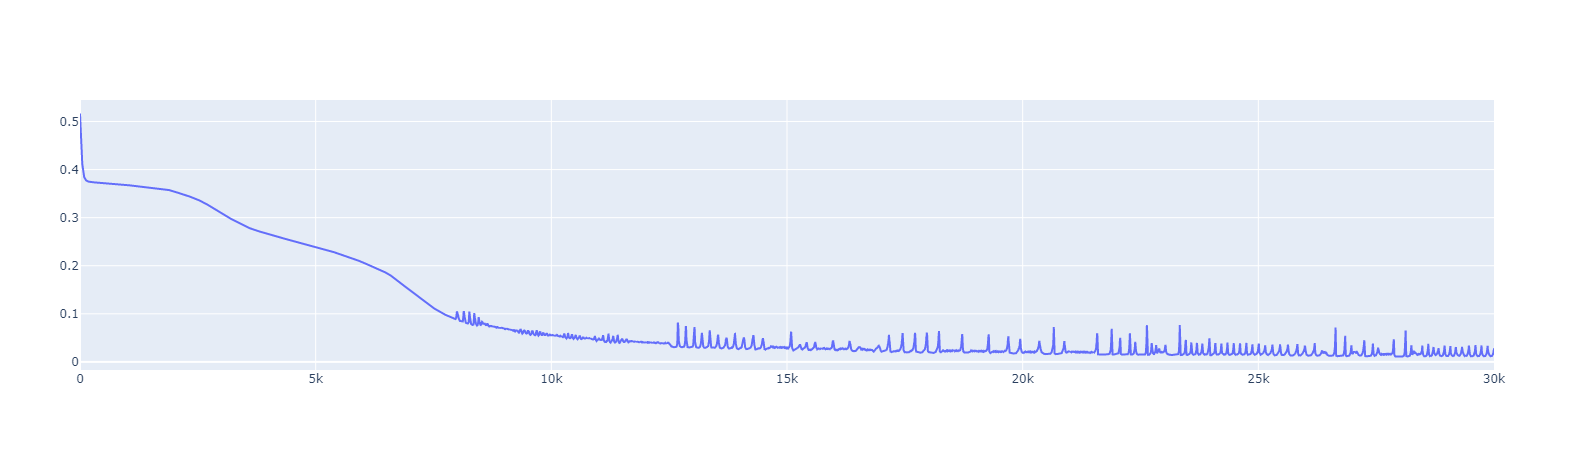

In [899]:
#Sanity check the loss
x = np.arange(len(circle_loss_history))
fig = go.Figure(data=go.Scatter(x=x, y=circle_loss_history))
fig.show()

In [921]:
# Set model to evaluation mode to prevent weights from updating
for n in range(len(square_model_history)):
    circle_model_history[n].eval()
    rotated_sin_model_history[n].eval()
    sin_model_history[n].eval()
    square_model_history[n].eval()

## Create new test data and convert to tensors

In [922]:
#test_data = generateCircle(5000, [5,5], 2)
test_circle = generateCircle(2000, [5,5], 2)
test_square = generateSquare(2000, [5,5], 2, 2)
test_sin = generateSin(2000)
test_rotated_sin = generateRotatedSin(2000)

circle_test_tensor = torch.tensor([test_circle['x'],test_circle['y']], requires_grad=False, device = device)
circle_test_tensor = torch.transpose(circle_test_tensor, 0, 1)

square_test_tensor = torch.tensor([test_square['x'],test_square['y']], requires_grad=False, device = device)
square_test_tensor = torch.transpose(square_test_tensor, 0, 1)

sin_test_tensor = torch.tensor([test_sin['x'],test_sin['y']], requires_grad=False, device = device)
sin_test_tensor = torch.transpose(sin_test_tensor, 0, 1)

rotated_sin_test_tensor = torch.tensor([test_rotated_sin['x'],test_rotated_sin['y']], requires_grad=False, device = device)
rotated_sin_test_tensor = torch.transpose(rotated_sin_test_tensor, 0, 1)

## Forward pass all the data through each historical model to get predictions

In [923]:
def create_result_df(df, x_test_tensor, models_history):
    for count, model in enumerate(models_history):
        pred = model.forward(x_test_tensor)
        df['pred-'+str(count)] = pred.tolist()
        df['pred-'+str(count)] = df['pred-'+str(count)].apply(lambda x: x[0]) 
    return df


test_circle = create_result_df(test_circle, circle_test_tensor, circle_model_history)
test_square = create_result_df(test_square, square_test_tensor, square_model_history)
test_sin = create_result_df(test_sin, sin_test_tensor, sin_model_history)
test_rotated_sin = create_result_df(test_rotated_sin, rotated_sin_test_tensor, rotated_sin_model_history)

In [938]:
test_rotated_sin

,x,y,out,pred-0,pred-1,pred-2,pred-3,pred-4,pred-5,pred-6,...,pred-51,pred-52,pred-53,pred-54,pred-55,pred-56,pred-57,pred-58,pred-59,pred-60
0,4.660619,4.451697,1.0,0.568543,0.550901,0.363829,0.277925,0.262696,0.262497,0.264844,...,0.764978,0.764237,0.762357,0.761527,0.763716,0.765339,0.765578,0.766911,0.766597,0.767727
1,7.754870,2.866003,0.0,0.566170,0.428757,0.188458,0.021765,0.005067,0.002070,0.001117,...,0.000042,0.000043,0.000043,0.000042,0.000042,0.000042,0.000041,0.000041,0.000041,0.000041
2,9.981174,0.728212,0.0,0.568185,0.425295,0.198461,0.024640,0.005762,0.002347,0.001260,...,0.000007,0.000007,0.000008,0.000008,0.000008,0.000008,0.000007,0.000005,0.000004,0.000002
3,7.023842,3.587952,0.0,0.567153,0.433740,0.184626,0.020797,0.004826,0.001972,0.001064,...,0.000323,0.000327,0.000327,0.000323,0.000320,0.000320,0.000316,0.000314,0.000310,0.000309
4,7.731595,2.214007,0.0,0.565456,0.426873,0.192056,0.024988,0.006307,0.002708,0.001513,...,0.000044,0.000045,0.000046,0.000046,0.000044,0.000039,0.000033,0.000029,0.000024,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8.700956,5.857571,0.0,0.569074,0.477585,0.172239,0.010109,0.001628,0.000678,0.000620,...,0.000127,0.000131,0.000133,0.000132,0.000131,0.000130,0.000129,0.000128,0.000126,0.000125
1996,0.949535,3.529250,1.0,0.566808,0.646627,0.963974,0.994742,0.996839,0.997041,0.997022,...,0.999990,0.999994,0.999996,0.999997,0.999998,0.999999,0.999999,0.999999,1.000000,1.000000
1997,7.435655,7.720301,0.0,0.568870,0.650246,0.600908,0.600477,0.611061,0.613680,0.613362,...,0.491761,0.496347,0.495414,0.494101,0.495682,0.497576,0.496087,0.498053,0.496616,0.498014
1998,1.271508,6.937271,1.0,0.566969,0.811475,0.999376,0.999991,0.999997,0.999998,0.999998,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Matplotlib animation

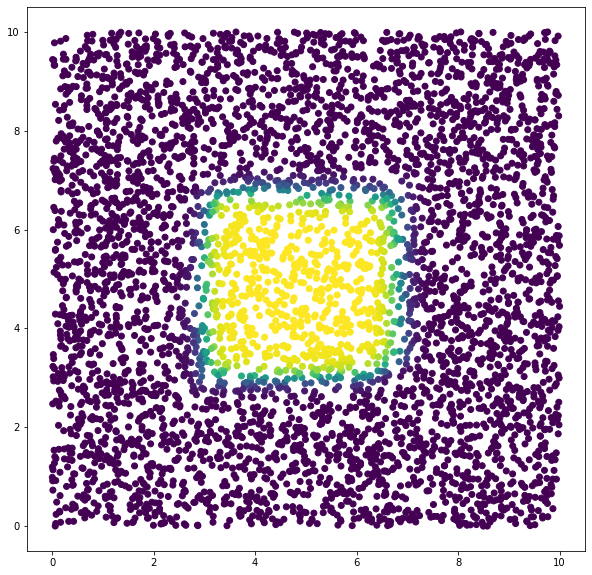

In [584]:
camera = Camera(plt.figure(figsize=(10, 10)))
for _ in range(41):
    plt.scatter("x", "y", c="pred-"+str(_), data=test_data )
    camera.snap()
anim = camera.animate(blit=True)
anim.save("MLP-sqaure.mp4")

# Create animation of each model learning

In [2]:
# Get the x axis for each loss graph
x_loss = np.arange(len(square_loss_history))
#Get how big of a setp down the loss each frame
numer_frames = 60
loss_step = len(square_loss_history)/60

#Helper methods to update the loss graph easier
def get_loss_x(n):
    return loss_step*n

def get_loss_y(n, history):
    x = int(loss_step*n)
    return history[x]

# Create figure
fig = make_subplots(rows=2, cols=4, subplot_titles = ('Square Pred', 'Circle Pred','Sine Pred', 'Rotated Sin Pred', 'Square Loss', 'Circle Loss','Sine Loss', 'Rotated Sin Loss' ))

#----------------- Square --------------------------------
fig.add_trace(
    go.Scatter(x=test_square['x'], y=test_square['y'],
                     mode="markers",
                     marker = dict(color=test_square["pred-0"])),
        row=1, col=1)

fig.add_shape(type="rect",
    xref="x", yref="y",
    fillcolor="green",
    opacity=0.4,
    x0=3, y0=3, x1=7, y1=7,      
    line_color="red",
    row=1, col=1
)
fig.add_trace(
        go.Scatter(x=x_loss, y=square_loss_history),row=2, col=1)
fig.add_trace(
        go.Scatter(x=[x_loss[0]], y=[square_loss_history[0]],mode="markers"),row=2, col=1)


#----------------- Circle ----------------- 
fig.add_trace(
    go.Scatter(x=test_circle['x'], y=test_circle['y'],
                     mode="markers",
                     marker = dict(color=test_circle["pred-0"])),
        row=1, col=2)

fig.add_shape(type="circle",
    xref="x", yref="y",
    fillcolor="green",
    opacity=0.4,
    x0=3, y0=3, x1=7, y1=7,      
    line_color="red",
    row=1, col=2
)

fig.add_trace(
        go.Scatter(x=x_loss, y=circle_loss_history),row=2, col=2)
fig.add_trace(
        go.Scatter(x=[x_loss[0]], y=[circle_loss_history[0]],mode="markers"),row=2, col=2)


#----------------- Sin ----------------- 
fig.add_trace(
    go.Scatter(x=test_sin['x'], y=test_sin['y'],
                     mode="markers",
                     marker = dict(color=test_sin["pred-0"])),
        row=1, col=3)
fig.add_trace(
        go.Scatter(x=x_loss, y=sin_loss_history),row=2, col=3)
fig.add_trace(
        go.Scatter(x=[x_loss[0]], y=[sin_loss_history[0]],mode="markers"),row=2, col=3)


#----------------- Rotated Sin ----------------- 
fig.add_trace(
    go.Scatter(x=test_rotated_sin['x'], y=test_rotated_sin['y'],
                     mode="markers",
                     marker = dict(color=test_rotated_sin["pred-0"])),
        row=1, col=4)
fig.add_trace(
        go.Scatter(x=x_loss, y=rotated_sin_loss_history),row=2, col=4)
fig.add_trace(
        go.Scatter(x=[x_loss[0]], y=[rotated_sin_loss_history[0]],mode="markers"),row=2, col=4)



# Sin/Rotated sin static graph
t = np.linspace(0, 10, 100)


fig.add_trace(
    go.Scatter(x=t, y = np.sin(t)*4,  mode = 'lines'),
    row=1, col=3
)

fig.add_trace(
    go.Scatter(x=t, y = np.sin(t)+t,  mode = 'lines'),
    row=1, col=4
)



#----------------- Animation ----------------- 

frames=[dict(
    name = k,
    data = [go.Scatter(x=test_square['x'], y=test_square['y'],mode="markers",
            marker=dict(color=test_square["pred-" +str(k)])),
            go.Scatter(x=x_loss, y=square_loss_history),
            go.Scatter(x=[get_loss_x(k)], y=[get_loss_y(k,square_loss_history)],mode="markers"),
            
            go.Scatter(x=test_circle['x'], y=test_circle['y'],mode="markers",
            marker=dict(color=test_circle["pred-" +str(k)])),
            go.Scatter(x=x_loss, y=circle_loss_history),
            go.Scatter(x=[get_loss_x(k)], y=[get_loss_y(k,circle_loss_history)],mode="markers"),
            
            go.Scatter(x=test_sin['x'], y=test_sin['y'],mode="markers",
            marker=dict(color=test_sin["pred-" +str(k)])),
            go.Scatter(x=x_loss, y=sin_loss_history),
            go.Scatter(x=[get_loss_x(k)], y=[get_loss_y(k,sin_loss_history)],mode="markers"),
            
            go.Scatter(x=test_rotated_sin['x'], y=test_rotated_sin['y'],mode="markers",
            marker=dict(color=test_rotated_sin["pred-" +str(k)])),
            go.Scatter(x=x_loss, y=rotated_sin_loss_history),
            go.Scatter(x=[get_loss_x(k)], y=[get_loss_y(k,rotated_sin_loss_history)],mode="markers"),
           ],
    traces=[0,1,2,3,4,5,6,7,8,9,10,11]
    ) for k in range(numer_frames)]


#----------------- Controls ----------------- 
updatemenus = [dict(type='buttons',
                    buttons=[dict(label='Play',
                                  method='animate',
                                  args=[[f'{k}' for k in range(60)], 
                                         dict(frame=dict(duration=500, redraw=False), 
                                              transition=dict(duration=0),
                                              easing='linear',
                                              fromcurrent=True,
                                              mode='immediate'
                                                                 )])],
                    direction= 'left', 
                    pad=dict(r= 10, t=85), 
                    showactive =True, x= 0.1, y= 0, xanchor= 'right', yanchor= 'top')
            ]


sliders = [{'yanchor': 'top',
            'xanchor': 'left', 
            'currentvalue': {'font': {'size': 16}, 'prefix': 'Frame: ', 'visible': True, 'xanchor': 'right'},
            'transition': {'duration': 500.0, 'easing': 'linear'},
            'pad': {'b': 10, 't': 50}, 
            'len': 0.9, 'x': 0.1, 'y': 0, 
            'steps': [{'args': [[k], {'frame': {'duration': 500.0, 'easing': 'linear', 'redraw': False},
                                      'transition': {'duration': 0, 'easing': 'linear'}}], 
                       'label': k, 'method': 'animate'} for k in range(60)       
                    ]}]
                
# -----------------  Formating -----------------     
fig.update(frames=frames),
fig.update_layout(width=800, height=800)
fig.update_layout(updatemenus=updatemenus, sliders=sliders)
fig.update_yaxes(range=[0, 10], row=1, col=1)
fig.update_yaxes(range=[0, 10], row=1, col=2)
fig.update_yaxes(range=[0, 10], row=1, col=3)
fig.update_yaxes(range=[0, 10], row=1, col=4)
fig.update_xaxes(range=[0, 10], row=1, col=1)
fig.update_xaxes(range=[0, 10], row=1, col=2)
fig.update_xaxes(range=[0, 10], row=1, col=3)
fig.update_xaxes(range=[0, 10], row=1, col=4)
fig.update_layout(showlegend=False)
#fig.show()

NameError: name 'np' is not defined

In [933]:

fig.write_html("Training.html")